In [3]:
from os import listdir

noise_files = ["Snoring Dataset/0/"+f for f in listdir("Snoring Dataset/0/") if f.endswith(".wav") ]

snoring_files = ["Snoring Dataset/1/"+f for f in listdir("Snoring Dataset/1/") if f.endswith(".wav") ]

Forming dataset from periodograms of initial signals

In [5]:
import numpy as np
from scipy.io import wavfile
import pandas as pd
from scipy import signal

def set_crt(lst):
    data = pd.DataFrame(columns=range(0,65))
    for f in lst:
        w = wavfile.read(f)
        if isinstance(w[1][1], np.ndarray):
            p = signal.welch([i[0] for i in w[1]][0:44100], nperseg=128)
        else:
            p = signal.welch(w[1][0:44100], nperseg=128)
        w = pd.Series(p[1],index = data.columns)
        data = data.append(w,ignore_index=True)
    return(data)

In [6]:
snr_data = set_crt(snoring_files)

noise_data = set_crt(noise_files)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  if __name__ == '__main__':


In [7]:
snr_data['class'] = 1

noise_data['class'] = 0  

Check for Na-values

In [8]:
snr_data.isnull().values.any()

False

In [9]:
noise_data.isnull().values.any()

False

Visual comparison of snoring and other noise periodograms

Text(0.5, 1.0, 'Noise')

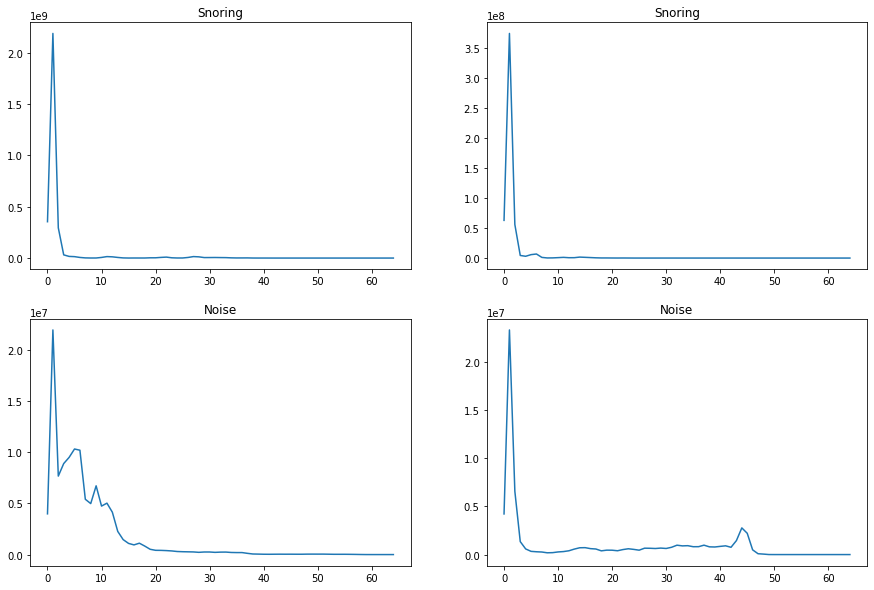

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,2,figsize=(15,10))

ax[0,0].plot(snr_data.iloc[0,0:65])
ax[0,0].set_title('Snoring')
ax[0,1].plot(snr_data.iloc[100,0:65])
ax[0,1].set_title('Snoring')

ax[1,0].plot(noise_data.iloc[0,0:65])
ax[1,0].set_title('Noise')
ax[1,1].plot(noise_data.iloc[0,0:65])
ax[1,1].set_title('Noise')


Creating a common dataset and normalization for PCA application

In [11]:
full_set = pd.concat([snr_data,noise_data])

In [12]:
full_set['class'] = full_set['class'].astype('category')

m_v = max(full_set.iloc[:,0:65].max())

full_set.iloc[:,0:65] = full_set.iloc[:,0:65] / m_v

Testing models

In [13]:
X = full_set.loc[:,full_set.columns != 'class']
y = full_set['class']

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

pca = PCA()

pipe = Pipeline(steps=[('pca', pca), ('rfc', rfc)])

parameters = {'pca__n_components':[5,10,15,20],'rfc__criterion':['gini', 'entropy'],
              'rfc__n_estimators':[10,15,20,25,30,35,40,45,50],
              'rfc__max_depth':[8,10,12,14,15,20,25,30, 35,40,45] }


estimator = GridSearchCV(pipe,parameters, cv = 5, scoring = 'accuracy')

estimator.fit(X, y)
print('Best Score: {} \nBest hyperparameters {}'.format(estimator.best_score_,estimator.best_params_))

Best Score: 0.974 
Best hyperparameters {'pca__n_components': 15, 'rfc__criterion': 'gini', 'rfc__max_depth': 14, 'rfc__n_estimators': 50}


In [16]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()

pipeGB = Pipeline(steps=[('pca', pca), ('gbc', gbc)])

parametersGB = {'pca__n_components':[5,10,15,20],
                'gbc__learning_rate':[0.01,0.03,0.1,0.2,0.3,0.4,0.5],
                'gbc__n_estimators':[10,15,20,25,30,35,40,45,50], 
                'gbc__max_depth':[3,4,5,6,7,8,9,10] }

estimatorGB = GridSearchCV(pipeGB,parametersGB, cv = 5, scoring = 'accuracy')

estimatorGB.fit(X, y)

print('Best Score: {} \nBest hyperparameters {}'.format(estimatorGB.best_score_,estimatorGB.best_params_))

Best Score: 0.9710000000000001 
Best hyperparameters {'gbc__learning_rate': 0.4, 'gbc__max_depth': 6, 'gbc__n_estimators': 45, 'pca__n_components': 20}


In [20]:
from catboost import CatBoostClassifier

cbc = CatBoostClassifier()

pipeCB = Pipeline(steps=[('pca', pca), ('cbc', cbc)])

parametersCB = {'pca__n_components':[5,10,15,20],
                'cbc__learning_rate':[0.01,0.03,0.1,0.2,0.3,0.4,0.5], 
                'cbc__iterations':[10,15,20,25,30,35,40,45,50], 
                'cbc__depth':[3,4,5,6,7,8,9,10] ,
                'cbc__logging_level':['Silent']}

estimatorCB = GridSearchCV(pipeCB, parametersCB, cv = 5, scoring = 'accuracy')

estimatorCB.fit(X, y)

print('Best Score: {} \nBest hyperparameters {}'.format(estimatorCB.best_score_,estimatorCB.best_params_))

Best Score: 0.974 
Best hyperparameters {'cbc__depth': 10, 'cbc__iterations': 30, 'cbc__learning_rate': 0.4, 'cbc__logging_level': 'Silent', 'pca__n_components': 20}


In [21]:
import xgboost as xgb

cxgb = xgb.XGBClassifier(use_label_encoder=False,TREE_METHOD = 'gpu_hist')

pca = PCA()

pipeCB = Pipeline(steps=[('pca', pca), ('cxgb', cxgb)])

parametersXGB = {'pca__n_components':[5,10,15,20],
                 'cxgb__eta':[0.01,0.03,0.1,0.2,0.3,0.4,0.5],
                 'cxgb__n_estimators':[10,15,20,25,30,35,40,45,50],
                 'cxgb__max_depth':[3,4,5,6,7,8,9,10] ,
                 'cxgb__eval_metric': ['logloss']}

estimatorXGB = GridSearchCV(pipeCB, parametersXGB, cv = 5, scoring = 'accuracy')

estimatorXGB.fit(X, y.cat.codes)

print('Best Score: {} \nBest hyperparameters {}'.format(estimatorXGB.best_score_,estimatorXGB.best_params_))

Best Score: 0.9629999999999999 
Best hyperparameters {'cxgb__eta': 0.01, 'cxgb__eval_metric': 'logloss', 'cxgb__max_depth': 6, 'cxgb__n_estimators': 50, 'pca__n_components': 20}
